In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [14]:
def get_splits_gain(tree_num = 0, parent = -1, tree = None, lev = 0, node_name = None, split_gain = None, reclimit = 50000):
    if tree == None:
        raise Exception('No tree present to analyze!')
    for k, v in tree.items():
        if type(v) != dict and k in ['split_feature']:
            old_parent = parent
            parent = v
            tag = k
            yield tree_num, tag, old_parent, parent, lev, node_name, split_gain
        elif isinstance(v, dict):
            if v.get('split_gain') == None:
                continue
            else:
                tree = v
                lev_inc = lev + 1
                node_name = k
                split_gain = v['split_gain']
                for result in get_splits_gain(tree_num, parent, tree, lev_inc, node_name, split_gain):
                    yield result
        else: continue

def plot_feat_interaction(model):
    dumped_model = model.dump_model()
    tree_info = []
    for j in range(0, len(dumped_model['tree_info'])):
        for i in get_splits_gain(tree_num = j, tree = dumped_model['tree_info'][j]):
            tree_info.append(list(i))
    tree_info_df = pd.DataFrame(tree_info, columns = ['TreeNo', 'Type', 'ParentFeature', 'SplitOnfeature', 'Level', 'TreePos', 'Gain'])
    lgbm_feat_dict = dict(enumerate(dumped_model['feature_names']))
    lgbm_feat_dict[-1] = 'base'
    tree_info_df['ParentFeature'].replace(lgbm_feat_dict, inplace = True)
    tree_info_df['SplitOnfeature'].replace(lgbm_feat_dict, inplace = True)
    tree_info_df['Interactions'] = tree_info_df['ParentFeature'].map(str) + ' - ' + tree_info_df['SplitOnfeature'].map(str)
    tree_info_df = round(tree_info_df, 2)
    lgb_inter_calc = tree_info_df.groupby('Interactions')['Gain'].agg(['count','sum','min','max','mean','std']).sort_values(by='sum', ascending=False).reset_index('Interactions').fillna(0)
    lgb_inter_calc = round(lgb_inter_calc, 2)
    lgb_inter_calc_nobase = lgb_inter_calc[lgb_inter_calc['Interactions'].str.contains('base')==False]
    data = lgb_inter_calc_nobase.sort_values('sum', ascending=False).iloc[0:75].reset_index(drop=True)
    plt.figure(figsize=(20, 14))
    ax = plt.subplot(121)
    sns.barplot(x='sum', y='Interactions', data=data.sort_values('sum', ascending=False), ax=ax)
    ax.set_title('Total Gain for Feature Interaction', fontweight='bold', fontsize=14)
    ax = plt.subplot(122)
    sns.barplot(x='count', y='Interactions', data=data.sort_values('sum', ascending=False), ax=ax)
    ax.set_title('No. of times Feature interacted', fontweight='bold', fontsize=14)
    plt.tight_layout()
    

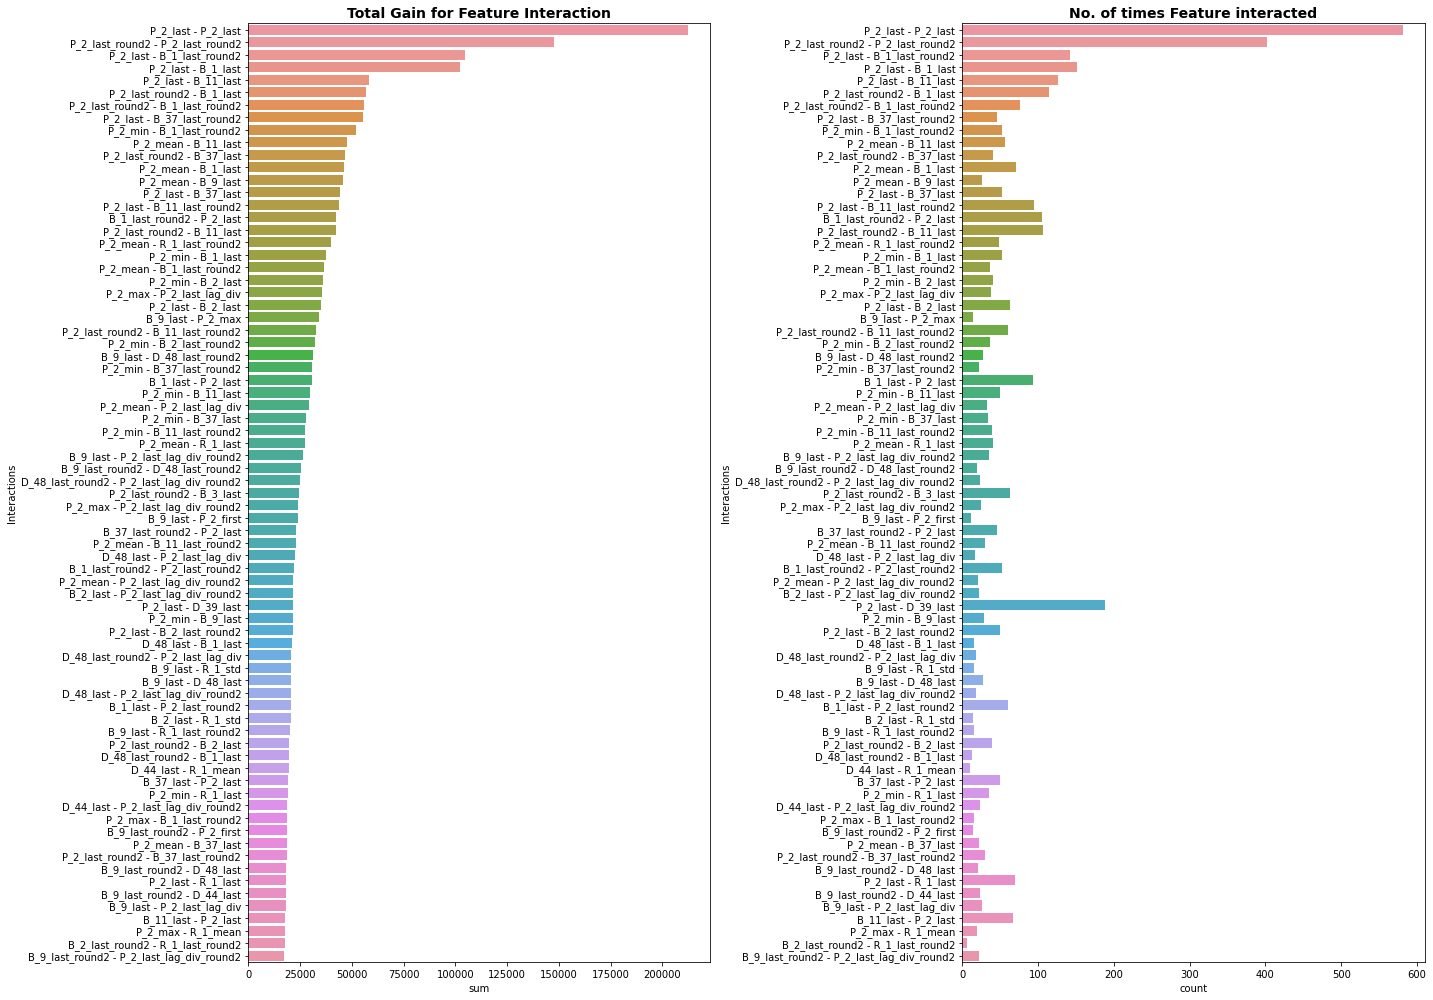

In [15]:
fold = 1
seed = 98

with open(f'lgbm_v2_fold{fold}_seed{seed}.pkl', 'rb') as f:
    model = pickle.load(f)
plot_feat_interaction(model)